# TCC - Helder Rezende

# Apresentação TCC

In [21]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas.io.data as web
import seaborn as sns
import statsmodels.api as sm
import arch 
plt.style.use('ggplot')

%matplotlib inline

## Pegando a cotação da Ibovespa de 2012 até a data atual

In [22]:
cotacoes = web.DataReader('^BVSP', data_source='yahoo', start='1/1/2000')['Close']

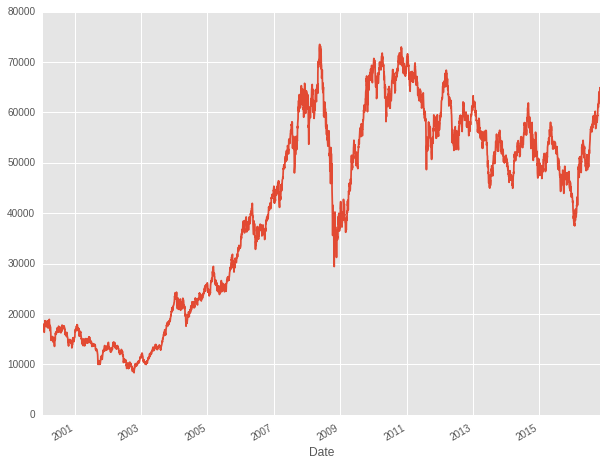

In [23]:
cotacoes[5:].plot(figsize = (10,8))
plt.savefig('cotacao_bovespa.png',bbox_inches='tight')

## Calculando os Retornos

In [24]:
retornos = (cotacoes / cotacoes.shift(1) -1)

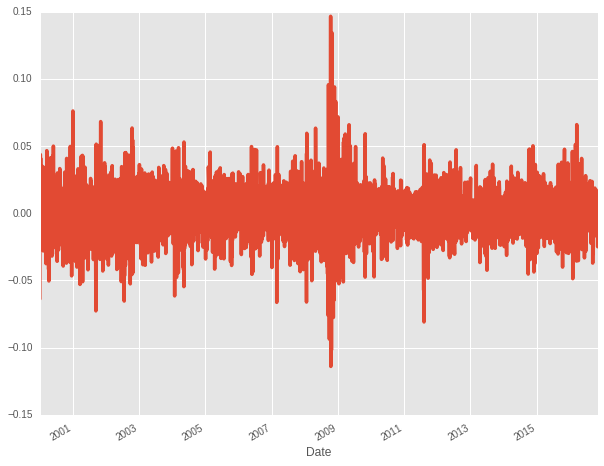

In [25]:
retornos.plot(figsize = (10,8),linewidth=3.5)

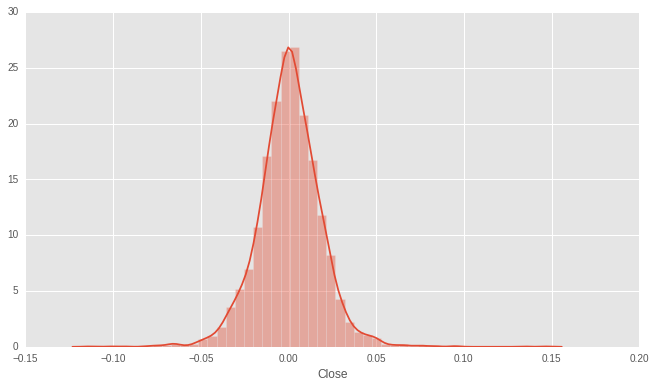

In [26]:
f, ax = plt.subplots(figsize=(11, 6))
sns.distplot(retornos.dropna())
plt.savefig('retornos_ambev.png',bbox_inches='tight')

## Calculando, por fim, a volalitidade ao longo do tempo.

In [27]:
volatilidade_valores = []
#retornos = pd.DataFrame(retornos)


In [28]:
volatilidade_valores = pd.rolling_std(retornos,30)*100*sqrt(252)
#for x in range(len(retornos)):
#    volatilidade_valores.append(pd.rolling_std(retornos[:x],30)*100*sqrt(252))


/home/helder/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).std()
  if __name__ == '__main__':


In [29]:
volatilidade = pd.DataFrame(volatilidade_valores, index = retornos.index,columns = ["Index IBOVESPA"])

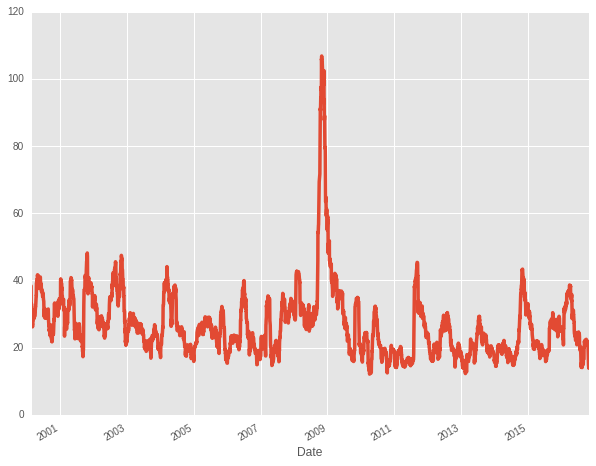

In [30]:
volatilidade_valores[30:].plot(figsize = (10,8),linewidth=3.5)
plt.savefig('volatilidade_bovespa.png',bbox_inches='tight')

## TCC

### Using Extreme Value Theory and Copulas to Evaluate Market Risk



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


In [31]:
iniditalDate = "1/1/2014"
ativos = ['ABEV3', 'PETR4','RADL3','BBDC4']

In [32]:
cotacoesAmbev = web.DataReader('ABEV3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesRadl = web.DataReader('RADL3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start=iniditalDate)['Close']


In [33]:
cotacoes = [cotacoesAmbev,cotacoesPetr,cotacoesRadl,cotacoesBbdc]
cotacoesPandas = pd.DataFrame(index = ativos, data = cotacoes)


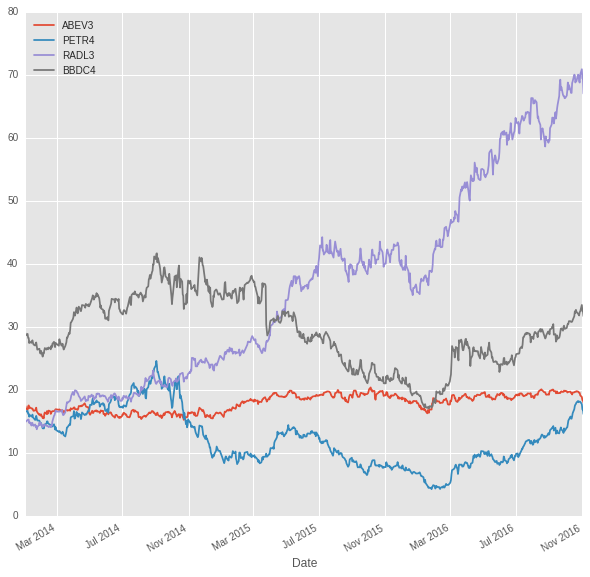

In [34]:
cotacoesPandas.transpose().dropna().plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

In [35]:
def logReturn(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

In [36]:
returns = [logReturn(cotacoes[x]) for x in range(len(cotacoes))]
returnsPandas = pd.DataFrame(index = ativos, data = returns)
returnsPandas = returnsPandas.transpose().dropna()

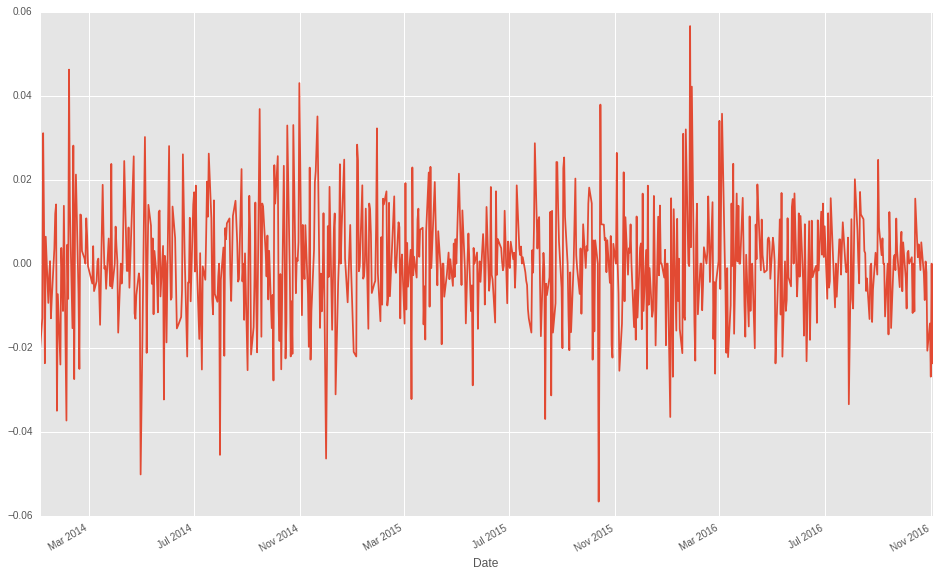

In [37]:
returnsPandas["ABEV3"].plot(figsize=(16,10))

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

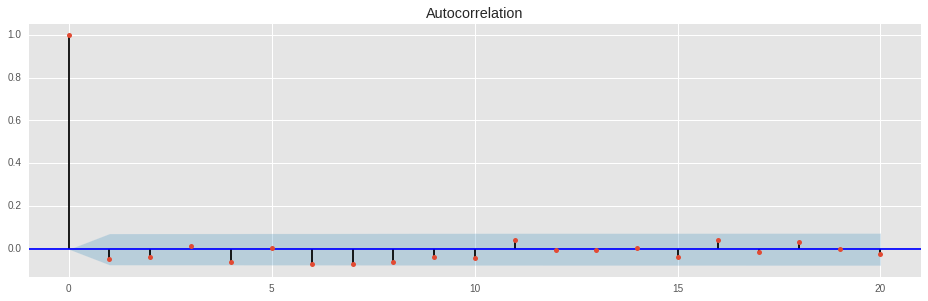

In [38]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"], lags=20, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

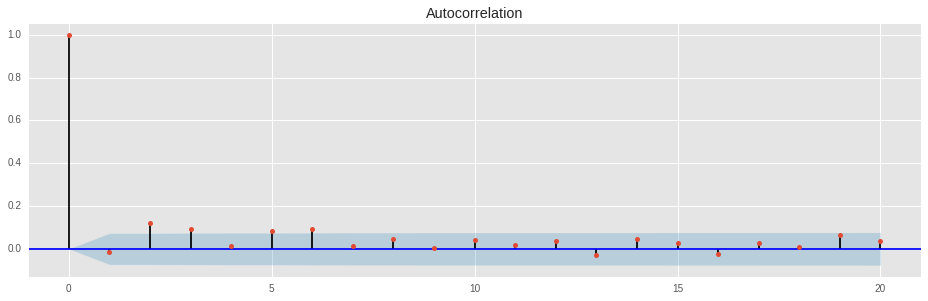

In [39]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"]**2, lags=20, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} + \psi[\epsilon_{t-1}<0]\epsilon^2_{t-1}$$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. In particular, the last term incorporates asymmetry (leverage) into the variance by a Boolean indicator that takes the value 1 if the prior model residual is negative and 0 otherwise (see Glosten, Jagannathan, & Runkle [3]).

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.